# Outline

HEADSS is a package made up of multiple functions with dependencies as follows,

- *headss_plotting*  - Allows a 2D visualisation of the split and stitch regions for any N.

- *headss_regions*   - Provides the split and stitch regions numerically from a given dataset. Also, can split the given data into clustering regions.

- *headss_HDBSCAN*   - Clusters the data using HDBSCAN, if alternative clustering is required do not use this ability.

- *headss_stitching* - Stitches clustered feature space based on the cluster central points and stitching regions from "headss_regions"".

- *headss_merge*     - If individual clusters span large fractions of the feature space use this to merge clusters split by HEADSS back together.


In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from HEADSS import *
from matplotlib.colors import ListedColormap

def reduce_intesity(cmap = 'prism', intensity = 0.75, plot = False): 
    '''Reduce the intensity of bright colormaps'''
    cmap = plt.cm.get_cmap(cmap)
    # Get the colormap colors, multiply them with the factor "a", and create new colormap
    my_cmap = cmap(np.arange(cmap.N))
    my_cmap[:,0:3] *= intensity
    my_cmap = ListedColormap(my_cmap)
    if plot:
        np.random.seed(1)
        data =  np.sort(np.random.rand(8,12))
        plt.figure()
        plt.subplot(121)
        c = plt.pcolor(data, edgecolors='k', linewidths=4, cmap=cmap, vmin=0.0, vmax=1.0)
        plt.colorbar(c)
        plt.subplot(122)
        c = plt.pcolor(data, edgecolors='k', linewidths=4, cmap=my_cmap, vmin=0.0, vmax=1.0)
        plt.colorbar(c)
        plt.show()
    return my_cmap

def savefigs(filename, dpi = 450):
    plt.savefig(f'plots/{filename}.png',
                dpi=dpi, bbox_inches = 'tight')
    plt.savefig(f'plots/{filename}.pdf',
                dpi=dpi, bbox_inches = 'tight')

# Create less intense colormaps.
reduced_prism = reduce_intesity(cmap = 'prism', intensity = 0.85, plot = False)
reduced_tab20 = reduce_intesity(cmap = 'tab20', intensity = 0.85, plot = False)

/tmp/ipykernel_724783/1351758010.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(cmap)


In [2]:
import pandas as pd
print(pd.__version__)

2.0.3


# Explore the scaling of N_regions
With HEADSS the number of regions scales with both the number of cuts (N) and the number of features. This is best visualised which we do below.

In [3]:
def get_ax(ax, figsize = None):
    '''returns an axis if ax = None in plotting functions'''
    if ax == None:
        fig, ax = plt.subplots(1,1, figsize = figsize)
    return ax

def getNregions(N, N_cols):
        '''Returns number of regions needed'''
        return (2*N-1)**N_cols
    
def N_regions_N_base_trend(N_max = 10, N_features = 2, fontsize = 16, ax = None, 
                           plot = False, figsize = (6,4)):
    '''return the number of regions for a range of N base cuts with N_features.'''
    lst = []
    ax = get_ax(ax = ax, figsize = figsize)
    for i in range(1,N_max+1):
        N = getNregions(i, N_features)
        lst.append(N)
    if plot:
        plt.rcParams['font.size'] = fontsize
        ax.plot(range(1,N_max+1), lst, c = 'k', ms = 10, ls = '--', lw = 1, marker = '.')
        ax.set_xlabel('NxN Base Grid Size', fontsize = fontsize)
        ax.set_ylabel('Number of Regions', fontsize = fontsize)
    return lst
def N_regions_N_cols_trend(N_features_max = 10, N = 2, fontsize = 16, ax = None, 
                           plot = False, figsize = (6,4), subplots = False):
    '''return the number of regions for a range of N_features with N base cuts.'''
    lst = []
    ax = get_ax(ax = ax, figsize = figsize)
    for i in range(1,N_features_max+1):
        N_regions = getNregions(N, i)
        lst.append(N_regions)
    if plot:
        plt.rcParams['font.size'] = fontsize
        plt.plot(range(1,N_features_max+1), lst, c = 'k', ms = 10, ls = '--', 
                 lw = 1, marker = '.')
        plt.xlabel('Number of Features', fontsize = fontsize)
        if not subplots:
            plt.ylabel('Number of Regions', fontsize = fontsize)
        plt.yscale('log')
    return lst

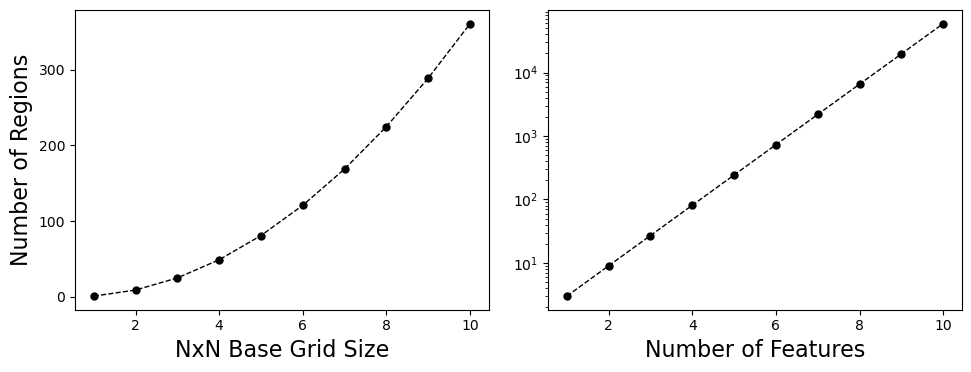

In [4]:
def N_region_scaling(fontsize = 16, figsize = (10,4)):
    '''Plot the number of regions for a range of N base layers (N = 0-10) with 2 features 
    compared to the number of regions for a range of features (0-10) with an N=2 
    base layer.'''
    
    fig, axes = plt.subplots(1,2, figsize = figsize)
    plt.rcParams['font.size'] = fontsize
    axs = axes.ravel()
    N_regionsBase = N_regions_N_base_trend(N_max = 10, fontsize = fontsize, 
                                           plot = True, ax = axs[0])
    N_regionsCols = N_regions_N_cols_trend(N_features_max = 10, fontsize = fontsize,
                                           plot = True, ax = axs[1], subplots = True)
    plt.tight_layout()
    plt.show()

N_region_scaling()


# Import Example Datasets

Example datasets are the best way to test the process and here we provide 10 example testsets that each provide a different challenge. We define a set of plotting parameters to ensure decent plotting of each example dataset throughout the notebook.

In [5]:
'''Plotting functions for example datasets'''

def getPlottingWormsParams():
    '''Parameters for improved "worms" visualisation'''
    xlim = ylim = (1800,5500)
    alpha = 0.05
    s = 1
    return xlim, ylim, alpha, s

def getPlottingBirch1Params():
    '''Parameters for improved "birch1" visualisation'''
    xlim = ylim = (0,1e6)
    alpha = 0.25
    s = 1
    return xlim, ylim, alpha, s

def getPlottingParams(dataset, size = 15):
    '''Parameters for all example datasets visualisations'''
    if dataset == 'worms':
        xlim, ylim, alpha, size = getPlottingWormsParams()
    elif dataset == 'birch1':
        xlim, ylim, alpha, size = getPlottingBirch1Params()
    else: xlim = ylim = None; alpha = 1; size = size
    return xlim, ylim, alpha, size

def plotData(data, dataset = None, cols = ['x', 'y'], color = 'k', ax = None, 
             axis = True, fontsize = 14, cmap = 'tab20c', size = 15):
    """Plots example datasets
    INPUT
           data              - data to plot [Pandas DataFrame]
        dataset = None       - dataset name for plotting parameters 
                                   (see "getPlottingParams")
           cols = ['x', 'y'] - columns to be plotted [list]
          color = 'k'        - marker color [str]
             ax = None       - Subplot axis if multiple plots are desired
           axis = True       - Show axis [bool]
          color = 'k'        - marker color [str or data[column] for cmap].
           size = 15         - markersize [int]
        """
    ax = get_ax(ax = ax)
    xlim, ylim, alpha, size = getPlottingParams(dataset, size = size)
    ax.scatter(data[cols[0]], data[cols[1]], s = size, alpha = alpha, 
               c = color, cmap = cmap)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title(dataset, fontsize = fontsize+4)
    if not axis:
        ax.set_xticks([])
        ax.set_yticks([])   

In [6]:
def open_txt_file(filename):
    '''opens txt files and returns as a list'''
    f = open(filename, "r")
    d = f.read()
    d = d.split('\n')
    return d

def getData(dataset, plot = False, ax = None, axis = True, fontsize = 16, size = 15):
    '''Opens example datasets returning them as a Pandas DataFrame'''
    
    filename = '../test_data/'
    known_types = ['Aggregation','a3','flame','pathbased','spiral','D31',
                   'birch1','jain','t4.8k', 'worms']
    # Open data
    if dataset == 'worms':
        data = open_txt_file(f'{filename}worms/worms_2d.txt')
    elif dataset != 'worms' and dataset in known_types:
        data = open_txt_file(f'{filename}{dataset}.txt')
    else:
        raise NameError(f'Known synthetic datatypes include {known_types}')
    data = [i.split() for i in data] # Split data types
    data = pd.DataFrame(data[:-1]).astype(float) # move into Pandas
    # Rename features as x,y ignoring additional columns
    data = data.rename(columns = {0:'x', 1:'y'})
    if plot: # Simple plotting feature for visualisation
        plotData(data = data, dataset = dataset, ax = ax, axis = axis, 
                 fontsize = fontsize, size = size)
    return data

/tmp/ipykernel_724783/2382119844.py:42: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(data[cols[0]], data[cols[1]], s = size, alpha = alpha,
/tmp/ipykernel_724783/2382119844.py:42: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(data[cols[0]], data[cols[1]], s = size, alpha = alpha,
/tmp/ipykernel_724783/2382119844.py:42: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(data[cols[0]], data[cols[1]], s = size, alpha = alpha,
/tmp/ipykernel_724783/2382119844.py:42: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(data[cols[0]], data[cols[1]], s = size, alpha = alpha,
/tmp/ipykernel_724783/2382119844.py:42: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(data[cols[0]], data[cols[1]], s = size, alpha = alpha,
/tmp/ipyke

Dataset = Aggregation | 788 datapoints
Dataset = a3 | 7500 datapoints
Dataset = flame | 240 datapoints
Dataset = pathbased | 300 datapoints
Dataset = spiral | 312 datapoints
Dataset = D31 | 3100 datapoints
Dataset = birch1 | 100000 datapoints
Dataset = jain | 373 datapoints
Dataset = t4.8k | 8000 datapoints


/tmp/ipykernel_724783/2382119844.py:42: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(data[cols[0]], data[cols[1]], s = size, alpha = alpha,


Dataset = worms | 105600 datapoints


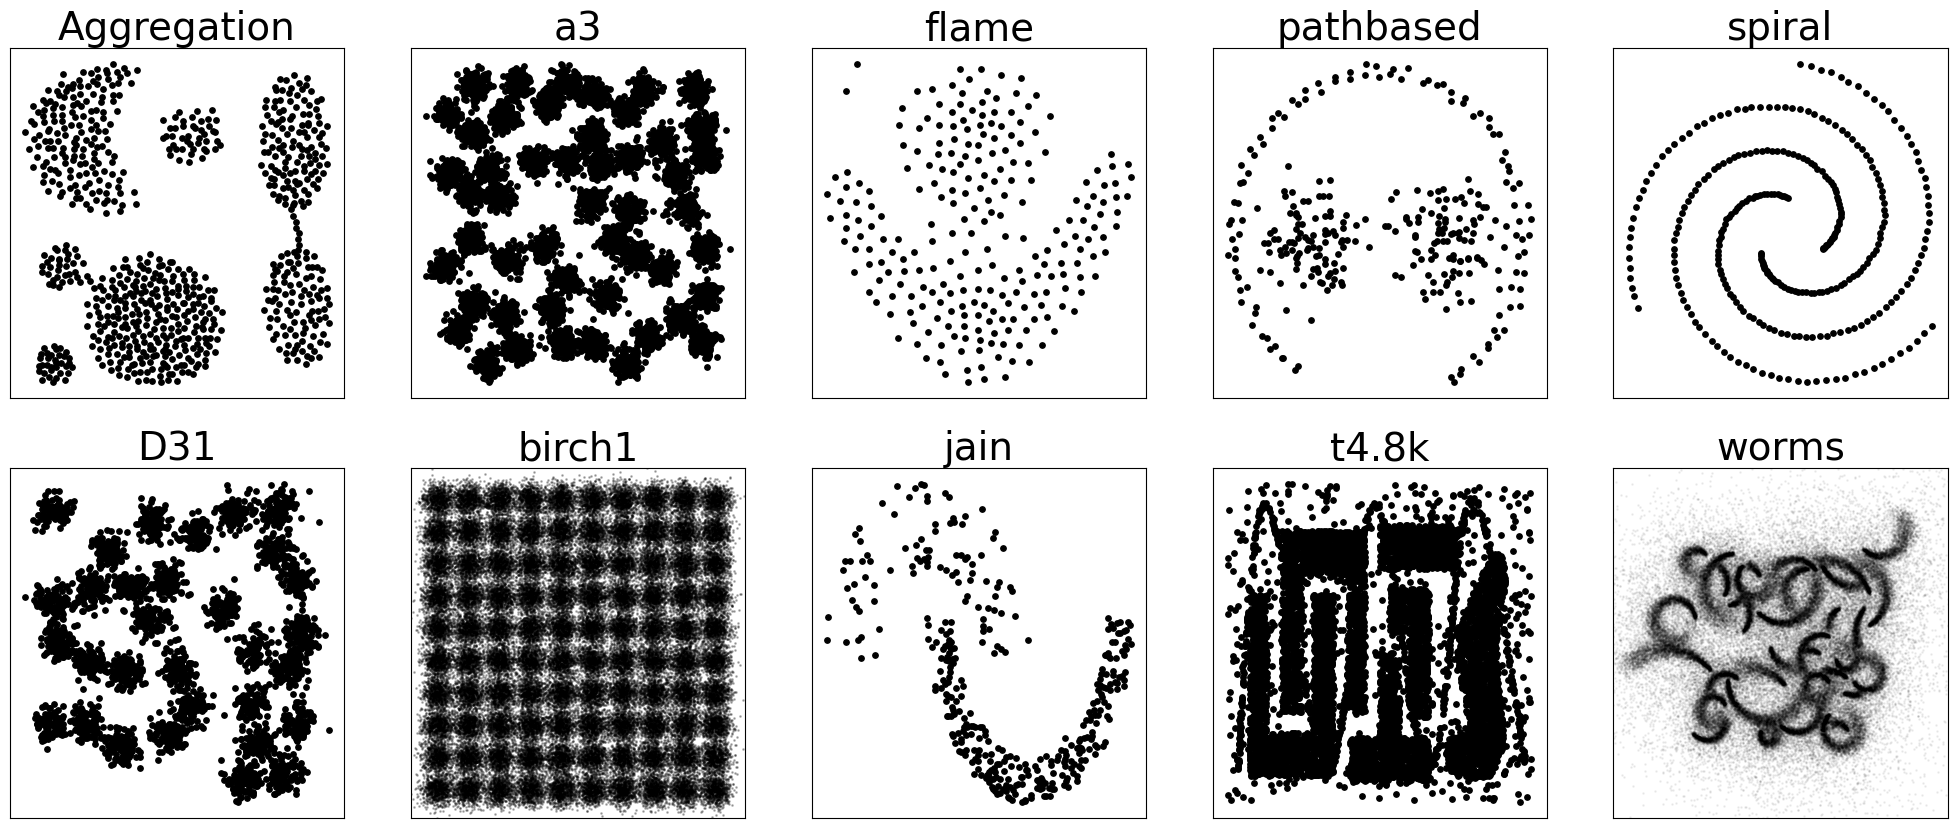

In [7]:
def show_available_data(known_types, fontsize = 16):
    '''plot all example datasets'''
    
    fig, axes = plt.subplots(2,5, figsize = (25, 10))
    axs = axes.ravel()
    for i, dataset in enumerate(known_types):
        data = getData(dataset = dataset, plot = True,
                       ax = axs[i], axis = False, fontsize = fontsize)
        print(f'Dataset = {dataset} | {len(data)} datapoints') # Dataset info

# list of example datasets
known_types = ['Aggregation','a3','flame','pathbased','spiral','D31',
                   'birch1','jain','t4.8k', 'worms']
show_available_data(known_types, fontsize = 24,)
plt.show()

# Explore headss_plotting

### Input:

- N - Number of cuts in base layer [int]
- show = False - Show both plots when called [bool]

### Output:
- plot_splitting - 2D plots of the splitting process [plot]
- plot_stitching - 2D plots of the stitching process [plot]

#### Recommendations:

- Keep N below 10, this ensures the plots are readable and will not cause large run times.

In [8]:
plotting = headss_plotting(N = 5, show = False)

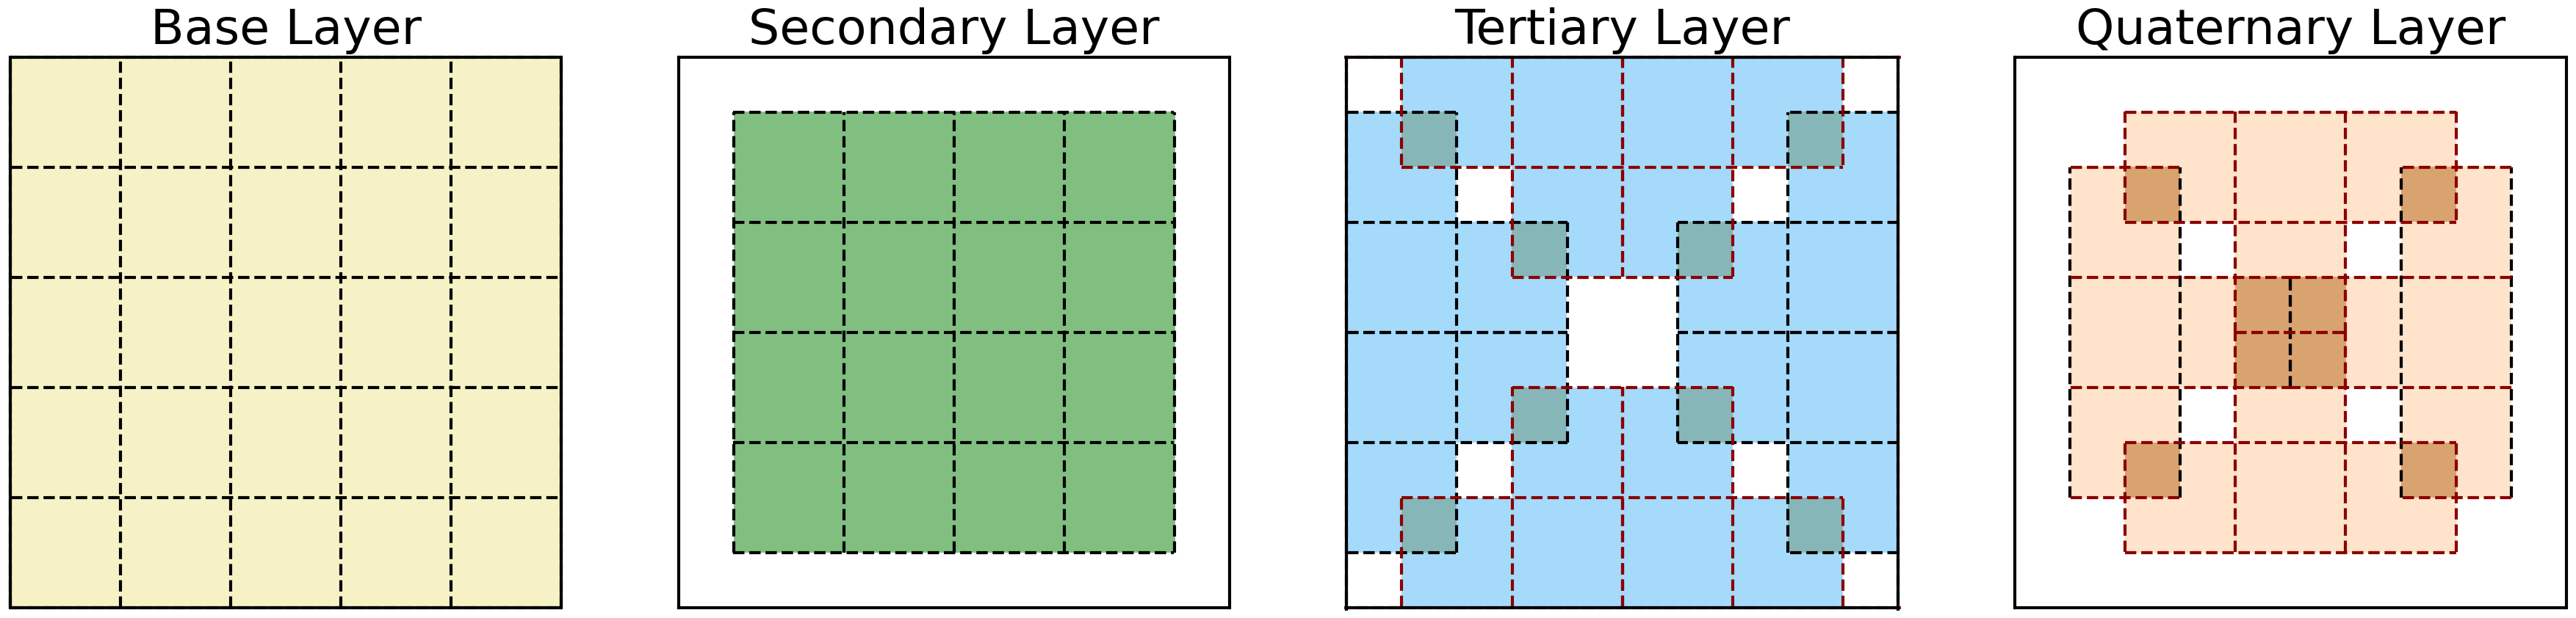

In [9]:
plotting.plot_splitting()

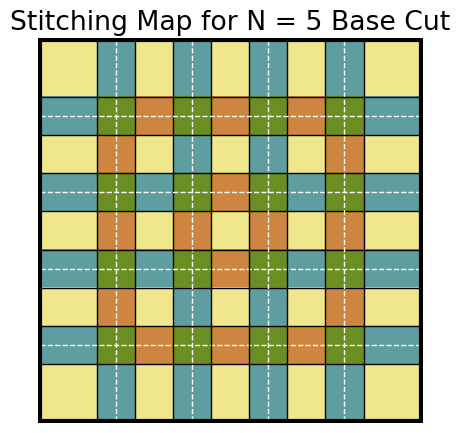

In [10]:
plotting.plot_stitching()

# Explore *headss_regions*

### Input:
- #### Inherited:
    - N - Number of cuts in the base layer. [int]
- #### New:
    - df - Data to be split. [pd.DataFrame]
    - split_columns - Columns to be used for splitting. [list]

### Output:
- #### Inherited:
    - plot_splitting - 2D plots of the splitting process [plot]
    - plot_stitching - 2D plots of the stitching process [plot]
- #### New:
    - stitch_regions - returns a DataFrame of where the limits of each splitting region lie
    - split_regions  - returns a DataFrame of where the limits of each stitching region lie
    - split_data - returns the data as a DataFrame with a region column indicating split regions.

In [11]:
# open a test dataset
data = getData(dataset = 'flame')

In [12]:
data

,x,y,2
0,1.85,27.80,1.0
1,1.35,26.65,1.0
2,1.40,23.25,2.0
3,0.85,23.05,2.0
4,0.50,22.35,2.0
...,...,...,...
235,7.50,26.20,1.0
236,7.50,25.65,1.0
237,7.05,25.85,1.0
238,6.90,27.15,1.0


In [13]:
# Introduce the headss_region function.
head = headss_regions(N = 2, df = data, split_columns=['x','y'])
df = head.split_data
df

,x,y,2,region
0,1.35,20.90,2.0,0
1,1.25,20.35,2.0,0
2,1.75,20.05,2.0,0
3,2.00,20.60,2.0,0
4,2.50,21.00,2.0,0
...,...,...,...,...
624,7.55,24.85,1.0,8
625,7.40,25.25,1.0,8
626,7.70,26.65,1.0,8
627,7.50,26.20,1.0,8


In [14]:
# open a test dataset
data2 = getData(dataset = 'spiral')
head2 = headss_regions(N = 2, df = data2, split_columns=['x','y'])
df2 = head2.split_data
#df2.to_csv("../ground_truth/spiral_regions.csv")

In [15]:
# # Split regions if alternative approach is desired.
# head.split_regions.to_csv("../ground_truth/flame_split_regions.csv")
# head.stitch_regions.to_csv("../ground_truth/flame_stitch_regions.csv")

# head2.split_regions.to_csv("../ground_truth/spiral_split_regions.csv")
# head2.stitch_regions.to_csv("../ground_truth/spiral_stitch_regions.csv")

In [16]:
# Stitch regions if alternatvie approach is desired.
head.stitch_regions

,region,x_mins,y_mins,x_max,y_max
0,0,0.5000,14.45000,5.6375,19.45625
1,1,0.5000,19.45625,5.6375,22.79375
2,2,0.5000,22.79375,5.6375,27.80000
3,3,5.6375,14.45000,9.0625,19.45625
4,4,5.6375,19.45625,9.0625,22.79375
5,5,5.6375,22.79375,9.0625,27.80000
6,6,9.0625,14.45000,14.2000,19.45625
7,7,9.0625,19.45625,14.2000,22.79375
8,8,9.0625,22.79375,14.2000,27.80000


# Explore *headss_hdbscan*

Inherits all functionality from *headss_regions*. Built using HDBSCAN, see https://hdbscan.readthedocs.io/en/latest/api.html for details.

If a different clustering algorithm is desired, use the splitting function from *headss_regions*, cluster by region and input as "df_clustered" in *headss_stitching* or *headss_merge* to perform the stitching process on the clustered data. Note the format must be a np.array of pd.DataFrames with cluster labels titled 'group'.

### Input:
- #### Inherited:
    - N - Number of cuts in the base layer. [int]
    - df - Data to be split. [pd.DataFrame]
    - split_columns - Columns to be used for splitting. [list]
- #### New:
    - cluster_columns = None - Columns to be used for clustering. If None split columns are used. [None or list]
    - cluster = True - Perform clustering of each region [bool]

    - ##### HDBSCAN Params: (see docs for details)
        - min_cluster_size = 5 - The minimum size of clusters [int]
        - min_samples = None - The number of samples in a neighbourhood for a point to be considered a core point. [int]
        - cluster_method = 'eom' - The method used to select clusters from the condensed tree. ['leaf' or 'eom']
        - allow_single_cluster = False - allow single cluster results [bool]
    
### Output:
- #### Inherited:
    - plot_splitting - 2D plots of the splitting process [plot]
    - plot_stitching - 2D plots of the stitching process [plot]
    - stitch_regions - returns a DataFrame of where the limits of each splitting region lie
    - split_regions  - returns a DataFrame of where the limits of each stitching region lie
    - split_data - returns the data as a DataFrame with a region column indicating split regions.
- #### New:
    - members - np.array of pd.DataFrames containing the clustering of each region.

In [17]:
# open a test dataset
data = getData(dataset = 'a3')

In [18]:
# Introduce the headss_hdbscan function.
head = headss_hdbscan(df = data, N = 2, split_columns = ['x', 'y'], 
                      cluster_columns = ['x', 'y'])
members = head.members
members

array([            x        y  region  group
       0      8960.0  29349.0       0      2
       1      9566.0  30666.0       0      2
       2     10002.0  29085.0       0      2
       3      9051.0  28004.0       0      2
       4      8262.0  29745.0       0      2
       ...       ...      ...     ...    ...
       1787  12480.0   2858.0       0      5
       1788  12662.0   4290.0       0      5
       1789  12058.0   4701.0       0      5
       1790  13609.0   6846.0       0      5
       1791  14413.0   5510.0       0      5

       [1703 rows x 4 columns]              ,
                   x        y  region  group
       1792  30675.0  45875.0       1     12
       1793  30226.0  45636.0       1     12
       1794  28960.0  43900.0       1     12
       1795  29217.0  46188.0       1     12
       1796  30475.0  46664.0       1     12
       ...       ...      ...     ...    ...
       3555  16896.0  17874.0       1     15
       3556  18744.0  16957.0       1     15
       3

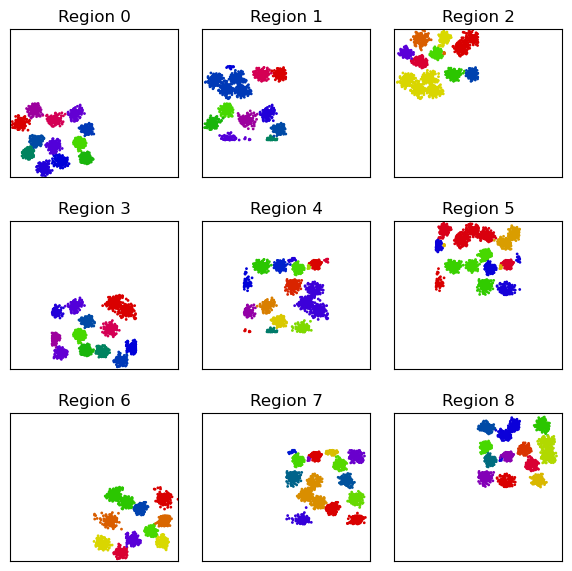

In [19]:
'''print clustering of each region. Notice the edge effects and overlapping between regions.'''

fig, ax = plt.subplots(3,3, figsize = (6, 6))
axs = ax.ravel()
for i,tmp in enumerate(members):
    axs[i].scatter(tmp.x, tmp.y, c = tmp.group, cmap = reduced_prism, alpha = 1, s =1)
    axs[i].set_xlim(data.x.min(), data.x.max()) # Set limits to reflect total dataset.
    axs[i].set_ylim(data.y.min(), data.y.max())
    axs[i].set_title(f'Region {i}', fontsize = 12)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.tight_layout()
plt.show()

# Explore *headss_stitching*

Inherits all functionality from *headss_HDBSCAN*.

### Input:
- #### Inherited
    - N - Number of cuts in the base layer. [int]
    - df - Data to be split. [pd.DataFrame]
    - split_columns - Columns to be used for splitting. [list]
    - cluster_columns = None - Columns to be used for clustering. If None split columns are used. [None or list]
    - cluster = True - Perform clustering of each region [bool]

    - ##### HDBSCAN Params: (see docs for details)
        - min_cluster_size = 5 - The minimum size of clusters [int]
        - min_samples = None - The number of samples in a neighbourhood for a point to be considered a core point. [int]
        - cluster_method = 'eom' - The method used to select clusters from the condensed tree. ['leaf' or 'eom']
        - allow_single_cluster = False - allow single cluster results [bool]
- #### New: 
    - df_clustered = False - Input to allow stitching on clustered data using an alternative clustering method. Note, using this feature disables the inheritance from the previous classes. "stitch regions" must be used.
    - stitch_regions - None - Must be used if df_clustered is used. See *headss_regions*.
    
### Output:
- #### Inherited:
    - plot_splitting - 2D plots of the splitting process [plot]
    - plot_stitching - 2D plots of the stitching process [plot]
    - stitch_regions - returns a DataFrame of where the limits of each splitting region lie
    - split_regions  - returns a DataFrame of where the limits of each stitching region lie
    - split_data - returns the data as a DataFrame with a region column indicating split regions.
    - members - np.array of pd.DataFrames containing the clustering of each region.
- #### New:
    - centers - np.array of cluster centers from each region. Median of each feature is used.
    - members_df - pd.DataFrame of final clusters after stitching process. Recall, any clustered centered outside of the stitching region is dropped.

In [35]:
# open a test dataset
data = getData(dataset = 'a3')

In [36]:
# Introduce the headss_stitching function.
stitch = headss_stitching(df = data, N = 2, split_columns = ['x', 'y'], 
                          cluster_columns=['x','y'], min_cluster_size = 20, 
                          min_samples = 20, cluster_method = 'leaf', 
                          allow_single_cluster = False)
members_df = stitch.members_df
members_df

,x,y,region,group,index
145,4764.0,24290.0,0,1,0
146,3241.0,23730.0,0,1,0
147,3373.0,24827.0,0,1,0
148,5567.0,22531.0,0,1,0
149,3190.0,24760.0,0,1,0
...,...,...,...,...,...
14086,48184.0,59753.0,8,108,8
14087,45657.0,57651.0,8,108,8
14088,48382.0,60296.0,8,108,8
14089,47369.0,59613.0,8,108,8


In [41]:
pd.concat(stitch.centers)

,group,x,y,N
0,0,9675.0,29483.0,145.0
1,1,4096.0,23903.5,140.0
2,2,17471.5,25260.0,142.0
3,3,25332.0,28160.0,144.0
4,4,7393.0,11245.0,143.0
...,...,...,...,...
9,112,44438.5,45900.5,130.0
10,113,35738.0,49995.0,113.0
11,114,37488.0,44007.0,115.0
12,115,60330.5,45797.0,94.0


In [ ]:
from headss.stitching import get_all_centers
get_all_centers(, split_columns=["x", "y"])

NameError: name 'dd' is not defined

In [42]:
stitch.stitch_regions

,region,x_mins,y_mins,x_max,y_max
0,0,0.000,976.00,24575.625,24663.25
1,1,0.000,24663.25,24575.625,40454.75
2,2,0.000,40454.75,24575.625,64142.00
3,3,24575.625,976.00,40959.375,24663.25
4,4,24575.625,24663.25,40959.375,40454.75
5,5,24575.625,40454.75,40959.375,64142.00
6,6,40959.375,976.00,65535.000,24663.25
7,7,40959.375,24663.25,65535.000,40454.75
8,8,40959.375,40454.75,65535.000,64142.00


In [ ]:
#members_df.to_csv("../tests/ground_truth/a3_stitching_result.csv")

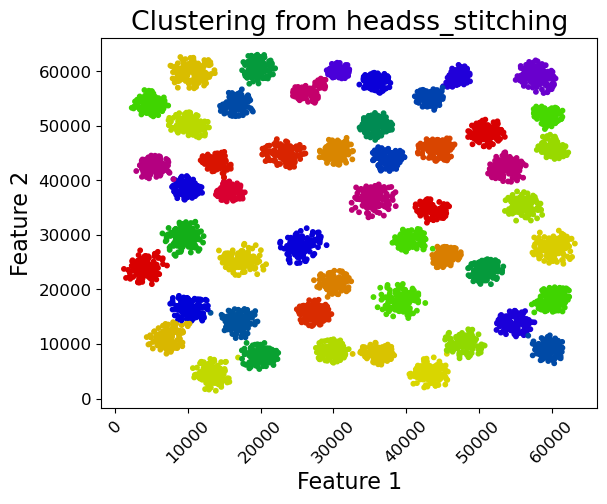

In [37]:
plt.scatter(members_df.x, members_df.y, c = members_df.group, 
            cmap =reduced_prism, s = 10)
plt.xlabel('Feature 1', fontsize = 16)
plt.ylabel('Feature 2', fontsize = 16)
plt.xticks(rotation = 45, fontsize = 12)
plt.yticks(rotation =  0, fontsize = 12)
plt.title('Clustering from headss_stitching')
plt.show()

# Explore *headss_merge*

Represents the final form of modified HEADSS including the functionality of all previous sections with the ability to merge large clusters. The simpliest implimentation of HEADSS is to input df here and this will perform all stages automatically.

Inherits all functionality from *headss_stitching*.

### Input:
- #### Inherited
    - N - Number of cuts in the base layer. [int]
    - df - Data to be split. [pd.DataFrame]
    - split_columns - Columns to be used for splitting. [list]
    - cluster_columns = None - Columns to be used for clustering. If None split columns are used. [None or list]
    - cluster = True - Perform clustering of each region [bool]
    - df_clustered = False - Input to allow stitching on clustered data using an alternative clustering method. Note, using this feature disables the inheritance from the previous classes. "stitch regions" must be used.
    - stitch_regions - None - Must be used if df_clustered is used. See *headss_regions*.

    - ##### HDBSCAN Params: (see docs for details)
        - min_cluster_size = 5 - The minimum size of clusters [int]
        - min_samples = None - The number of samples in a neighbourhood for a point to be considered a core point. [int]
        - cluster_method = 'eom' - The method used to select clusters from the condensed tree. ['leaf' or 'eom']
        - allow_single_cluster = False - allow single cluster results [bool]
- #### New: 
    - merge = False - Perform the merging of overlapping clusters. Only to be used if there are clusters that span a large fraction of feature space.
    - ##### Merge Parameters: 
        - overlap_threshold = 0.5 - fraction of mutual members in the overlapping region [float]
        - total_threshold = 0.1 - fraction of mutual members in the total cluster [float]
        - minimum_members = 10 - minimum members in the overlapping region [float]
    
    
### Output:
- #### Inherited:

    - plot_splitting - 2D plots of the splitting process [plot]
    - plot_stitching - 2D plots of the stitching process [plot]
    - stitch_regions - returns a DataFrame of where the limits of each splitting region lie
    - split_regions  - returns a DataFrame of where the limits of each stitching region lie
    - split_data - returns the data as a DataFrame with a region column indicating split regions.
    - members - np.array of pd.DataFrames containing the clustering of each region.
    - centers - np.array of cluster centers from each region. Median of each feature is used.
- #### New:

    - members_df - pd.DataFrame of final clusters after stitching AND merging processes. The final result is always here with or without merging.
    
    

In [23]:
# open a test dataset that requires merging
data = getData(dataset = 't4.8k')

In [24]:
unmerged = headss_merge(df = data, N = 2, split_columns = ['x', 'y'], merge = False,
                      cluster_columns=['x','y'], min_cluster_size = 30, 
                      min_samples = 10, cluster_method = 'eom', allow_single_cluster = False)
unmerged_df = unmerged.members_df

In [25]:
# Introduce the headss_merge function.
merge = headss_merge(df = data, N = 2, split_columns = ['x', 'y'], merge = True,
                      cluster_columns=['x','y'], min_cluster_size = 30, 
                      min_samples = 10, cluster_method = 'eom', allow_single_cluster = False,
                 total_threshold = 0.1, overlap_threshold = 0.5, minimum_members = 10) 

# clustering result post to merging
merged_df = merge.members_df

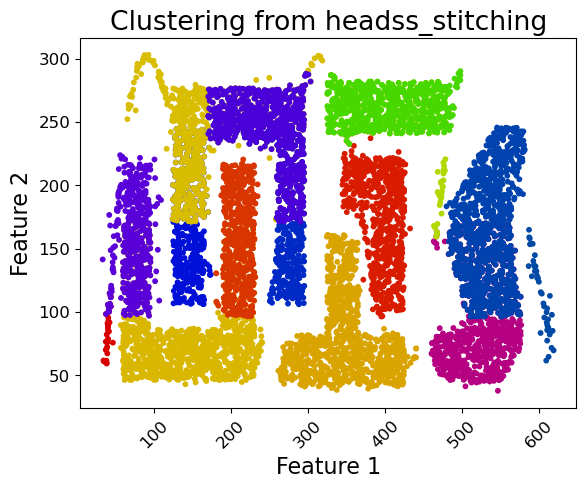

In [26]:
# Plot unmerged result
plt.scatter(unmerged_df.x, unmerged_df.y, c = unmerged_df.group, 
            cmap =reduced_prism, s = 10)
plt.xlabel('Feature 1', fontsize = 16)
plt.ylabel('Feature 2', fontsize = 16)
plt.xticks(rotation = 45, fontsize = 12)
plt.yticks(rotation =  0, fontsize = 12)
plt.title('Clustering from headss_stitching')
plt.show()

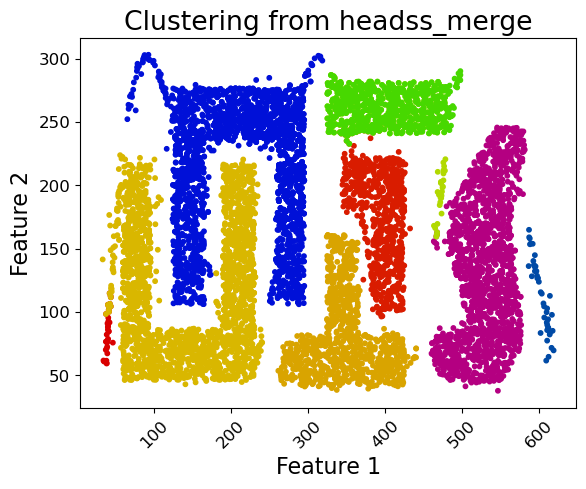

In [27]:
# Plot merged result.
plt.scatter(merged_df.x, merged_df.y, c = merged_df.group, 
            cmap =reduced_prism, s = 10)
plt.xlabel('Feature 1', fontsize = 16)
plt.ylabel('Feature 2', fontsize = 16)
plt.xticks(rotation = 45, fontsize = 12)
plt.yticks(rotation =  0, fontsize = 12)
plt.title('Clustering from headss_merge')
plt.show()

# Explore test Datasets

Use this space to use for experimenting with the above functions with access to any of the test datasets. These include:
- Aggregation
- a3
- flame
- pathbased 
- spiral
- D31
- birch1 - (Large dataset ~100,000 points)
- jain
- t4.8k
- worms - (Large dataset ~100,000 points)

Changing from "a3" will require changing the hyperparameters for optimal results.

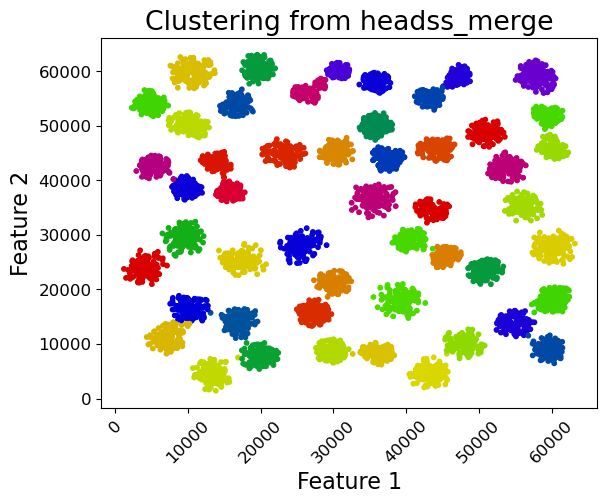

In [28]:
head = headss_merge(df = getData(dataset = 'a3'), split_columns = ['x', 'y'], 
                    N                    = 2, 
                    merge                = True,
                    min_samples          = 20,
                    cluster_method       = 'leaf',
                    allow_single_cluster = False,
                    min_cluster_size     = 20,
                    overlap_threshold    = 0.1,
                    total_threshold      = 0.5,
                    minimum_members      = 10)

df = head.members_df

plt.scatter(df.x, df.y, c = df.group, 
            cmap =reduced_prism, s = 10)
plt.xlabel('Feature 1', fontsize = 16)
plt.ylabel('Feature 2', fontsize = 16)
plt.xticks(rotation = 45, fontsize = 12)
plt.yticks(rotation =  0, fontsize = 12)
plt.title('Clustering from headss_merge')
plt.show()